# Enigma Coastline Analysis
## Setup
```bash
wget https://raw.githubusercontent.com/Enigma-Labs/explore-coastlines/main/scripts/setup.sh
chmod +x setup.sh
./setup.sh
```

In [1]:
# Get new token from https://enigmalabs.io/graphql
jwt = "Bearer eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IlVGa0I5cnRaS1RBVUVOaHR5YTBXZiJ9.eyJodHRwczovL2hhc3VyYS5pby9qd3QvY2xhaW1zIjp7IngtaGFzdXJhLWRlZmF1bHQtcm9sZSI6IndlYi11c2VyIiwieC1oYXN1cmEtYWxsb3dlZC1yb2xlcyI6WyJ3ZWItdXNlciIsIndlYi11c2VyIl0sIngtaGFzdXJhLXVzZXItaWQiOiJzYW1scHxTQU1MLUF1dGgwLUlEUHxpQGVuaWdtYWxhYnMuaW8iLCJ4LWhhc3VyYS13ZWItdXNlciI6IjEifSwiaXNzIjoiaHR0cHM6Ly9hdXRoLmVuaWdtYWxhYnMuaW8vIiwic3ViIjoic2FtbHB8U0FNTC1BdXRoMC1JRFB8aUBlbmlnbWFsYWJzLmlvIiwiYXVkIjpbImh0dHBzOi8vZW5pZ21hbGFicy5pbyIsImh0dHBzOi8vZW5pZ21hLWFwcC51cy5hdXRoMC5jb20vdXNlcmluZm8iXSwiaWF0IjoxNjQ0NDIxMDUwLCJleHAiOjE2NDQ0MjgyNTAsImF6cCI6Im1OMkJPa2FnT1lhQmI5Wktmc2QzVzJtNDZ0MnhoUGs3Iiwic2NvcGUiOiJvcGVuaWQgcHJvZmlsZSBlbWFpbCJ9.kL8DPEzLK_GeTFz0vQ9Ivm1jj94_xMK-Cdg6LTMw3RnSZDlvCyZdMk9JmtA9J_Yp0TuHRzxPBRhwYDNzzpa9XcqOyk9Nn7xzI3M8s1GIaYMD13aa3xa0CdmOl6NOVAUMlUCjMZF7oPW4VkilBe_fZVGScB2V54fJxl2gfAlzAxIILwUV8johwDrpGu5gKEtWOlZAS5zun-1qTf0f6bL5Ok3RAC2uynSGI7hch04mGVUcp9RMuhEd3D75ln3eUqKJG9EdSS8_hKOYbZwrL8NjRyJFyXGNf05FZDpT9WnxMIGbVOG30DocTxIgO1O4sg5jXDVaINa_-WiqhJsqNaoI0A"

# Default public token, do not modify
mapbox_token = "pk.eyJ1IjoiZW5pZ21hbGFicyIsImEiOiJja2prMzZ6NHA1YnppMnpucHIzdnc3d255In0.jPuo0Fn7BhDGGtlIQ1LotQ"

graphql_endpoint = 'https://gql.enigmalabs.io/v1/graphql'
headers = {'content-type': 'application/json',
           'Authorization': jwt,
           }
query = open("coastline_incidents.graphql", "r").read()


In [20]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["figure.autolayout"] = True

In [21]:
from geographiclib.geodesic import Geodesic
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import requests
import shapely
import ray


def get_least_distance(lat1, lon1, shoreline_segment):
    least = float('inf')
    for lon, lat in shoreline_segment.coords:
        g = geod.Inverse(lat1, lon1, lat, lon)
        least = min(least, g['s12'])
    return least


In [22]:
# Set geode geometry
geod = Geodesic.WGS84
# Load shapefile
shape_map = gpd.read_file('data/tl_2021_us_coastline.shp')


In [23]:
ray.shutdown()
ray.init()

def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [24]:
# Load incident data from GraphQL and flatten
incident_request = requests.post(
    graphql_endpoint,
    json={'query': query}, headers=headers
)

json_data = json.loads(incident_request.text)
df = pd.DataFrame([flatten_json(x) for x in json_data['data']['incident_survey']]).head(100)

lon_lat = [df['incident_location_center_coordinates_0'], df['incident_location_center_coordinates_1']]
incident_series = gpd.GeoDataFrame(gpd.points_from_xy(lon_lat[0], lon_lat[1]))
df = df.assign(point=incident_series) 

coastline_df = gpd.GeoSeries(shape_map['geometry'])


In [25]:
incidents_fig = go.Figure(go.Scattermapbox(
        lat=df.incident_location_center_coordinates_1,
        lon=df.incident_location_center_coordinates_0,
        mode='markers',
        marker=go.scattermapbox.Marker(
            color='#ff5935'
        )
    ))
incidents_fig.update_layout(
    mapbox_style='satellite', mapbox_accesstoken=mapbox_token)
incidents_fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
incidents_fig.show()


In [26]:

# Optional - plots the coastline
# lats = []
# lons = []

# for linestring in coastline_df:
#     x, y = linestring.xy
#     lats = np.append(lats, y)
#     lons = np.append(lons, x)
#     lats = np.append(lats, None)
#     lons = np.append(lons, None)

# fig = px.line_mapbox(lat=lats, lon=lons, center=dict(lat=37, lon=-100), zoom=2,
#                      mapbox_style='satellite')
# fig.show()

In [27]:
gpd.options.use_pygeos = True
geoseries = gpd.GeoSeries(df['point'].values)
nearest = coastline_df.sindex.nearest(geoseries, return_all=False)
shoreline_series = pd.Series(nearest[1], index=nearest[0]).apply(lambda x: coastline_df[x])
df = df.assign(shoreline=shoreline_series)

In [28]:
meter_to_mile= 0.000621371
def get_distance_tranform(record):
    coords = record.point.coords
    dist = get_least_distance(coords[0][1], coords[0][0], record.shoreline)
    return dist * meter_to_mile
df['distance_miles'] = df.apply(get_distance_tranform, axis=1)

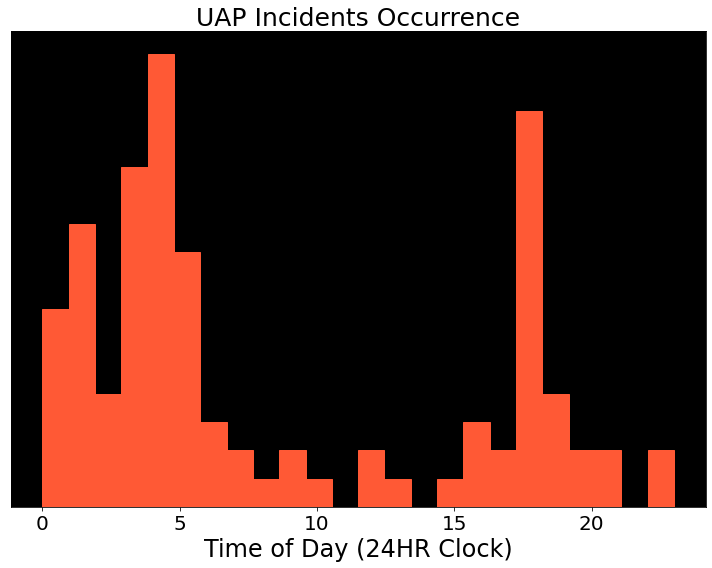

In [29]:
# Incident occurence hour
df[['incident_occured_at']].sort_values(by=['incident_occured_at'],ascending=False)
df['incident_occured_at_timestamp'] = df.incident_occured_at.apply(lambda x: pd.Timestamp(x))
df['incident_occured_at_hour'] = df.incident_occured_at_timestamp.apply(lambda x: x.hour)
bins = [-1, 6, 12, 18, 24]
categories = ['12AM-6AM', '6AM-12PM', '12PM-6PM', '6PM-12AM']
df['time_of_day'] = pd.cut(df['incident_occured_at_hour'], bins, labels=categories)
ax = df.hist(column = 'incident_occured_at_hour', bins=24, figsize=(10,8), color='#ff5935', grid=False, edgecolor='#ff5935')
for x in ax.flatten():
   x.set_xlabel('Time of Day (24HR Clock)', size=24)
   x.set_ylabel('Number of Incidents', size=0)
   x.get_yaxis().set_visible(False)
   x.tick_params(axis='x', labelsize=20)
   x.set_title("UAP Incidents Occurrence", size=25)
   x.set_facecolor('k')

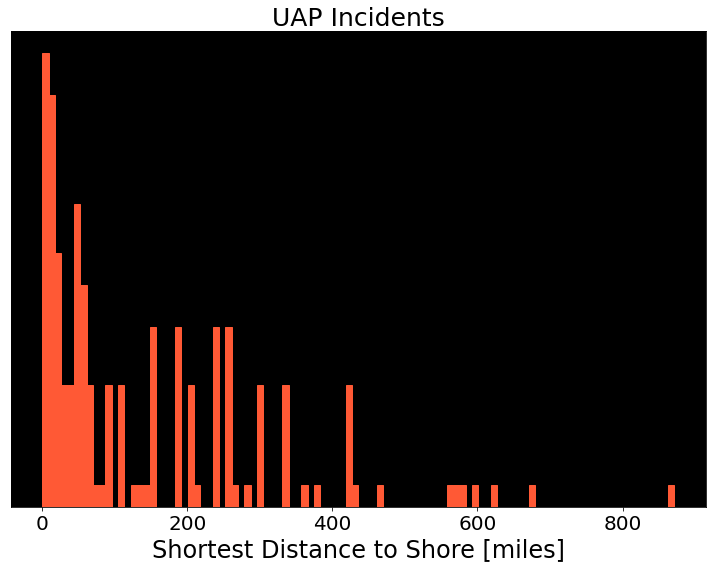

In [30]:
# Distance distribution
ax = df.hist(column='distance_miles', figsize=(10,8), bins=100, color='#ff5935', grid=False, edgecolor='#ff5935')
for x in ax.flatten():
  x.set_xlabel('Shortest Distance to Shore [miles]', size=24)
  x.set_ylabel('Number of Incidents', size=0)
  x.get_yaxis().set_visible(False)
  x.tick_params(axis='x', labelsize=20)
  x.set_title("UAP Incidents", size=25)
  x.set_yscale('log')
  x.set_facecolor('k')

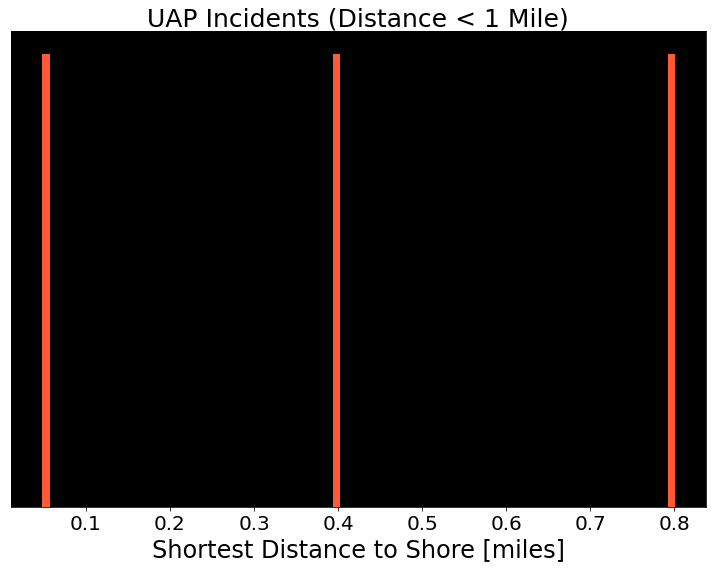

In [31]:
# Distance distribution of incidents within 1 mile of coastline
df_less_than_1_mile=df[df.distance_miles<1]
ax = df_less_than_1_mile.hist(column='distance_miles', figsize=(10,8), bins=100, color='#ff5935', grid=False, edgecolor='#ff5935')
for x in ax.flatten():
  x.set_xlabel('Shortest Distance to Shore [miles]', size=24)
  x.set_ylabel('Number of Incidents', size=0)
  x.get_yaxis().set_visible(False)
  x.tick_params(axis='x', labelsize=20)
  x.set_title("UAP Incidents (Distance < 1 Mile)", size=25)
  x.set_facecolor('k')

In [32]:
# Location of incidents within 1 mile of coastline
fig = go.Figure(go.Scattermapbox(
        lat=df_less_than_1_mile.incident_location_center_coordinates_1,
        lon=df_less_than_1_mile.incident_location_center_coordinates_0,
        mode='markers',
        marker=go.scattermapbox.Marker(
            color='#ff5935'
        )
    ))
fig.update_layout(mapbox_style='satellite', mapbox_accesstoken=mapbox_token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

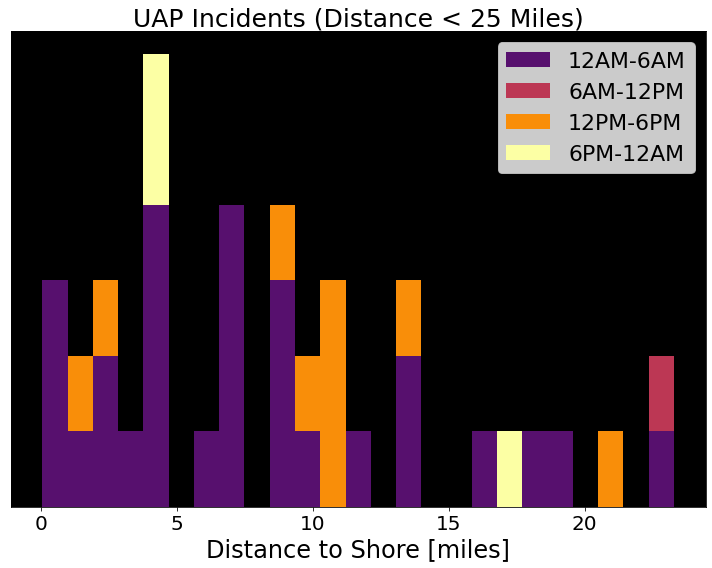

In [33]:
# Time-of-day in 6 hour segments for incidents within 25 miles to the coastline
df_less_than_25_mile=df[df.distance_miles<25]
my_colors = [plt.cm.inferno(i / 4 +0.25 ) for i in range(4)]
ax = df_less_than_25_mile.pivot(columns='time_of_day').distance_miles.plot(kind='hist', stacked=True, bins=25, color=my_colors)
ax.set_xlabel('Distance to Shore [miles]', size=24)
ax.set_ylabel('Number of Incidents', size=0)
ax.get_yaxis().set_visible(False)
ax.tick_params(axis='x', labelsize=20)
ax.set_title("UAP Incidents (Distance < 25 Miles)", size=25)
ax.set_facecolor('k')
plt.legend(fontsize=22)